In [7]:
# !pip install langchain-opentutorial

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH16-Agentic-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH16-Agentic-RAG


# Naive RAG

** 실습 자료 **

소프트웨어정책연구소(SPRi), [AI Brief 스페셜] AI 에이전트 동향

- 저자: 유재흥(AI정책연구실 책임연구원), 이해수(AI정책연구실 선임연구원)
- 발생: 2024.12.10
- 링크: https://spri.kr/posts/view/23798?code=AI-Brief&s_year=&data_page=1
- 파일명: `SPRi AI Brief_Special_AI Agent_241209_F`

(실습 준비)
- 작업 폴더 하위에 `data` 폴더 생성 
- 링크에서 다운로드 받은 파일을 `data` 폴더에 업로드 

In [3]:
file_path = ["data/SPRi AI Brief_Special_AI Agent_241209_F.pdf"]

### Chain 정의

- PDF 기반 Retrieval Chain 생성
- PDFRetrievalChain : https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi/blob/main/langchain_opentutorial/rag/pdf.py

In [4]:
from langchain_opentutorial.rag.pdf import PDFRetrievalChain

In [5]:
pdf_file = PDFRetrievalChain(file_path).create_chain()

pdf_retriever = pdf_file.retriever
pdf_chain = pdf_file.chain

In [6]:
search_result = pdf_retriever.invoke("Apple Intelligence 관련 내용을 문서에서 찾아주세요")
search_result

[Document(metadata={'source': 'data/SPRi AI Brief_Special_AI Agent_241209_F.pdf', 'file_path': 'data/SPRi AI Brief_Special_AI Agent_241209_F.pdf', 'page': 9, 'total_pages': 27, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13947', 'Producer': 'Hancom PDF 1.3.0.547', 'CreationDate': "D:20241209094315+09'00'", 'ModDate': "D:20241209094315+09'00'", 'PDFVersion': '1.4'}, page_content='iPhone, iPad, Mac, Apple Watch 등 자사 제품에 내장되어 사용자 경험을 강화\n∙ 최근 애플은 iPhone, iPad 및 Mac용 언어와 이미지를 이해하고 생성하고, 개인 컨텍스트에서 일상적인\n작업을 지원하는 기능을 제공하는 Apple Intelligence를 출시\n∙ Apple의 AI 기술은 사용자의 개인정보 보호를 중시하며 온디바이스 학습 방식을 채택\n<애플 인텔리전스(Apple Intelligence)>\n*출처: apple.com'),
 Document(metadata={'source': 'data/SPRi AI Brief_Special_AI Agent_241209_F.pdf', 'file_path': 'data/SPRi AI Brief_Special_AI Agent_241209_F.pdf', 'page': 10, 'total_pages': 27, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13947', 'Producer': 'Hancom PDF 1.3.0.547', 'CreationDate': "D:20241209094315+09'00'", 'ModDate': "D:20241209094315+09'00'", 'PDFV

In [7]:
# 이전에 검색한 결과를 chain의 context로 전달 
answer = pdf_chain.invoke(
    {
        "question": "Apple Intelligence 관련 내용을 문서에서 찾아주세요",
        "context": search_result,
        "chat_history": [],
    }
)

print(answer)

Apple Intelligence는 iPhone, iPad 및 Mac에서 언어와 이미지를 이해하고 생성하며, 개인 컨텍스트에서 일상적인 작업을 지원하는 기능을 제공합니다. 이 시스템은 사용자의 개인정보 보호를 중시하며 온디바이스 학습 방식을 채택하고 있습니다. 2024년 10월 28일에 공식 출시되었으며, 사용자는 글쓰기, 알림 및 메시지 요약, 이미지에서 방해물 제거 등의 작업을 수행할 수 있습니다.

**Source**
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 9)
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 10)


### State 정의

In [8]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

In [9]:
class GraphState(TypedDict):
    question: Annotated[str, "Question"]     # 질문
    context: Annotated[str, "Context"]       # 문서의 검색 결과
    answer: Annotated[str, "Answer"]         # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

### Node 정의

In [10]:
from langchain_opentutorial.rag.utils import format_docs
from langchain_teddynote.messages import messages_to_history

In [11]:
# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"]
    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = format_docs(retrieved_docs) # 검색된 문서를 형식화(프롬프트 입력으로 넣어주기 위함)
    # 검색된 문서를 context 키에 저장
    return GraphState(context=retrieved_docs)

# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    latest_question = state["question"]
    context = state["context"]

    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )

### 그래프 정의 

In [12]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

In [13]:
workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)         # 답변 -> 종료

workflow.set_entry_point("retrieve")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

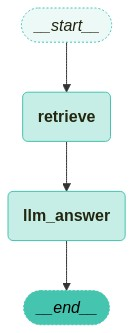

In [14]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

### 그래프 실행 

In [15]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

In [16]:
# config 설정
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="Apple Intelligence 관련 내용을 문서에서 찾아주세요")

# 그래프 실행
# stream_graph : 특정 노드만 스트리밍으로 출력하는 함수 
stream_graph(app, inputs, config, ["llm_answer"])


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Apple Intelligence는 iPhone, iPad 및 Mac에서 언어와 이미지를 이해하고 생성하며, 개인 컨텍스트에서 일상적인 작업을 지원하는 기능을 제공하는 시스템입니다. 이 시스템은 사용자의 개인정보 보호를 중시하며 온디바이스 학습 방식을 채택하고 있습니다. 2024년 10월 28일에 공식 출시되었으며, 사용자는 글쓰기, 알림 및 메일 요약, 이미지에서 방해물 제거 등의 작업을 수행할 수 있습니다.

**Source**
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 10)
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 11)

In [17]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: Apple Intelligence 관련 내용을 문서에서 찾아주세요
Answer:
Apple Intelligence는 iPhone, iPad 및 Mac에서 언어와 이미지를 이해하고 생성하며, 개인 컨텍스트에서 일상적인 작업을 지원하는 기능을 제공하는 시스템입니다. 이 시스템은 사용자의 개인정보 보호를 중시하며 온디바이스 학습 방식을 채택하고 있습니다. 2024년 10월 28일에 공식 출시되었으며, 사용자는 글쓰기, 알림 및 메일 요약, 이미지에서 방해물 제거 등의 작업을 수행할 수 있습니다.

**Source**
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 10)
- data/SPRi AI Brief_Special_AI Agent_241209_F.pdf (page 11)


<- 위 실행 내역을 LangSmith TRACE 통해 상세 확인하기

-----
** End of Documents **